# Proportion of treated patients by stroke type

## Code setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load data

Load the cleaned SSNAP extract data:

In [2]:
path_to_ssnap = '~/ssnap_data/clean_samuel_ssnap_extract_v2.csv'
df_ssnap = pd.read_csv(path_to_ssnap)

Check the available data in the file:

In [3]:
df_ssnap.columns

Index(['id', 'stroke_team', 'age', 'male', 'infarction',
       'onset_to_arrival_time', 'onset_known', 'precise_onset_known',
       'onset_during_sleep', 'arrive_by_ambulance',
       'call_to_ambulance_arrival_time', 'ambulance_on_scene_time',
       'ambulance_travel_to_hospital_time', 'ambulance_wait_time_at_hospital',
       'month', 'year', 'weekday', 'arrival_time_3_hour_period',
       'arrival_to_scan_time', 'thrombolysis', 'scan_to_thrombolysis_time',
       'thrombectomy', 'arrival_to_thrombectomy_time',
       'congestive_heart_failure', 'hypertension', 'atrial_fibrillation',
       'diabetes', 'prior_stroke_tia', 'afib_antiplatelet',
       'afib_anticoagulant', 'afib_vit_k_anticoagulant',
       'afib_doac_anticoagulant', 'afib_heparin_anticoagulant',
       'new_afib_diagnosis', 'prior_disability', 'stroke_severity',
       'nihss_complete', 'nihss_arrival_loc', 'nihss_arrival_loc_questions',
       'nihss_arrival_loc_commands', 'nihss_arrival_best_gaze',
       'nihss_

## Functions

The following function creates masks to say which patients meet which conditions.

Some patients have NIHSS of 10 or below and so would normally be classed as nLVO, but they also are recorded as having received a thrombectomy which should never happen for nLVO patients. So when thrombectomy is given, the patient is always classed as LVO regardless of their NIHSS score.

In [4]:
def make_masks(df):
    # Store masks in here:
    df_masks = pd.DataFrame()
    
    # Stroke type:
    df_masks['haemo'] = df['infarction'] == 0
    df_masks['lvo'] = (
        (
            (df['infarction'] == 1) & (df['stroke_severity'] > 10)
        ) | (df['thrombectomy'] == 1)
    )
    df_masks['nlvo'] = (
        (
            (df['infarction'] == 1) & (df['stroke_severity'] < 11)
        ) & (df['thrombectomy'] == 0)
    )

    # Treatment:
    df_masks['no_treatment'] = (df['thrombolysis'] == 0) & (df['thrombectomy'] == 0)
    df_masks['mt'] = df['thrombectomy'] == 1
    df_masks['ivt'] = df['thrombolysis'] == 1
    df_masks['ivt_mt'] = (df_masks['ivt'] & df_masks['mt'])

    return df_masks

The following function finds the proportions of patients who fall into each category. It uses the masks created in the previous function.

In [5]:
def make_props_from_masks(df, df_masks):
    # Store numbers of patients in here:
    dict_numbers = {}
    # Total number of patients:
    dict_numbers['total'] = len(df)
    # Stroke types:
    dict_numbers['haemo'] = len(df[df_masks['haemo']])
    dict_numbers['lvo'] = len(df[df_masks['lvo']])
    dict_numbers['nlvo'] = len(df[df_masks['nlvo']])
    # No treatment:
    dict_numbers['no_treatment'] = len(df[df_masks['no_treatment']])
    # No treatment split by stroke type:
    dict_numbers['haemo_no_treatment'] = len(df[df_masks['haemo'] & df_masks['no_treatment']])
    dict_numbers['lvo_no_treatment'] = len(df[df_masks['lvo'] & df_masks['no_treatment']])
    dict_numbers['nlvo_no_treatment'] = len(df[df_masks['nlvo'] & df_masks['no_treatment']])
    # Treatment:
    dict_numbers['mt'] = len(df[df_masks['mt']])
    dict_numbers['ivt'] = len(df[df_masks['ivt']])
    dict_numbers['ivt_mt'] = len(df[df_masks['ivt_mt']])
    # Treatment by stroke type:
    dict_numbers['lvo_ivt'] = len(df[df_masks['lvo'] & df_masks['ivt']])
    dict_numbers['nlvo_ivt'] = len(df[df_masks['nlvo'] & df_masks['ivt']])
    dict_numbers['lvo_ivt_only'] = len(df[df_masks['lvo'] & df_masks['ivt'] & ~df_masks['mt']])
    dict_numbers['lvo_mt_only'] = len(df[df_masks['lvo'] & ~df_masks['ivt'] & df_masks['mt']])
    dict_numbers['lvo_ivt_mt'] = len(df[df_masks['lvo'] & df_masks['ivt'] & df_masks['mt']])
    dict_numbers['nlvo_ivt_only'] = len(df[df_masks['nlvo'] & df_masks['ivt'] & ~df_masks['mt']])
    dict_numbers['nlvo_mt_only'] = len(df[df_masks['nlvo'] & ~df_masks['ivt'] & df_masks['mt']])
    dict_numbers['nlvo_ivt_mt'] = len(df[df_masks['nlvo'] & df_masks['ivt'] & df_masks['mt']])

    # Convert numbers into proportions:
    dict_props = {}
    for key, val in dict_numbers.items():
        dict_props[key] = val / dict_numbers['total']
    # Overwrite the total numbers of patients:
    dict_props['total'] = dict_numbers['total']

    # Add an extra proportion: how many people who received MT also received IVT?
    dict_props['mt_also_ivt'] = dict_numbers['ivt_mt'] / dict_numbers['mt']
    # Add an extra proportion: how many people who receive IVT have an LVO?
    dict_props['ivt_also_lvo'] = dict_numbers['lvo_ivt'] / dict_numbers['ivt']

    # Run sanity checks:
    sanity_checks(dict_props)
    return dict_props

The following function checks that the proportions add up as expected.

In [6]:
def sanity_checks(dict_props):
    # Number of decimal places to round to:
    d = 5

    if round(dict_props['haemo'], d) != round(dict_props['haemo_no_treatment'], 5):
        print('!   Haemorrhagic patients receive treatment.')
        for key in ['haemo', 'haemo_no_treatment']:
            print(f'    {key:20s}: {round(dict_props[key], d+1)}')

    p = (
        dict_props['lvo_ivt_only'] +
        dict_props['lvo_mt_only'] +
        dict_props['lvo_ivt_mt'] +
        dict_props['lvo_no_treatment']
    )
    if round(dict_props['lvo'], d) != round(p, d):
        print('!   LVO patients don\'t add up.')
        for key in ['lvo', 'lvo_ivt_only', 'lvo_mt_only', 'lvo_ivt_mt', 'lvo_no_treatment']:
            print(f'    {key:20s}: {round(dict_props[key], d+1)}')

    p = (
        dict_props['nlvo_ivt_only'] +
        dict_props['nlvo_mt_only'] +
        dict_props['nlvo_ivt_mt'] +
        dict_props['nlvo_no_treatment']
    )
    if round(dict_props['nlvo'], d) != round(p, d):
        print('!   nLVO patients don\'t add up.')
        for key in ['nlvo', 'nlvo_ivt_only', 'nlvo_mt_only', 'nlvo_ivt_mt', 'nlvo_no_treatment']:
            print(f'    {key:20s}: {round(dict_props[key], d+1)}')

    p = (
        dict_props['nlvo_ivt_only'] +
        dict_props['nlvo_ivt_mt'] +
        dict_props['lvo_ivt_only'] +
        dict_props['lvo_ivt_mt']
    )
    if round(dict_props['ivt'], d) != round(p, d):
        print('!   IVT patients don\'t add up.')
        for key in ['ivt', 'nlvo_ivt_only', 'nlvo_ivt_mt', 'lvo_ivt_only', 'lvo_ivt_mt']:
            print(f'    {key:20s}: {round(dict_props[key], d+1)}')

    p = (
        dict_props['nlvo_mt_only'] +
        dict_props['nlvo_ivt_mt'] +
        dict_props['lvo_mt_only'] +
        dict_props['lvo_ivt_mt']
    )
    if round(dict_props['mt'], d) != round(p, d):
        print('!   MT patients don\'t add up.')
        for key in ['mt', 'nlvo_mt_only', 'nlvo_ivt_mt', 'lvo_mt_only', 'lvo_ivt_mt']:
            print(f'    {key:20s}: {round(dict_props[key], d+1)}')

    p = (
        dict_props['nlvo_no_treatment'] +
        dict_props['lvo_no_treatment'] +
        dict_props['haemo_no_treatment']
    )
    if round(dict_props['no_treatment'], d) != round(p, d):
        print('!   No treatment patients don\'t add up.')
        for key in ['no_treatment', 'nlvo_no_treatment', 'lvo_no_treatment', 'haemo_no_treatment']:
            print(f'    {key:20s}: {round(dict_props[key], d+1)}')

    p = (
        dict_props['nlvo_ivt_only'] +
        dict_props['nlvo_mt_only'] +
        dict_props['nlvo_ivt_mt'] +
        dict_props['nlvo_no_treatment'] +
        dict_props['lvo_ivt_only'] +
        dict_props['lvo_mt_only'] +
        dict_props['lvo_ivt_mt'] +
        dict_props['lvo_no_treatment'] +
        dict_props['haemo_no_treatment']        
    )
    if round(1.0, d) != round(p, d):
        print('!   Total patients don\'t add up.')
        for key in ['nlvo_ivt_only', 'nlvo_mt_only', 'nlvo_ivt_mt', 'nlvo_no_treatment', 'lvo_ivt_only', 'lvo_mt_only', 'lvo_ivt_mt', 'lvo_no_treatment', 'haemo_no_treatment']:
            print(f'    {key:20s}: {round(dict_props[key], d+1)}')

## Results

Example for the full SSNAP data:

In [7]:
dict_props_full = make_props_from_masks(df_ssnap, make_masks(df_ssnap))

In [8]:
# Convert to Series for neater printing:
pd.Series(dict_props_full)

total                 358993.000000
haemo                      0.122153
lvo                        0.179432
nlvo                       0.698415
no_treatment               0.880457
haemo_no_treatment         0.122153
lvo_no_treatment           0.123665
nlvo_no_treatment          0.634639
mt                         0.012098
ivt                        0.114662
ivt_mt                     0.007217
lvo_ivt                    0.050887
nlvo_ivt                   0.063776
lvo_ivt_only               0.043669
lvo_mt_only                0.004880
lvo_ivt_mt                 0.007217
nlvo_ivt_only              0.063776
nlvo_mt_only               0.000000
nlvo_ivt_mt                0.000000
mt_also_ivt                0.596592
ivt_also_lvo               0.443797
dtype: float64

Calculate the proportions separately for various onset-to-arrival time cutoffs.

In [9]:
dict_props_by_time = {}

for time in np.arange(1.0, 25.0, 1.0):
    df_here = df_ssnap[df_ssnap['onset_to_arrival_time'] < time * 60.0].copy().reset_index()
    dict_props_here = make_props_from_masks(df_here, make_masks(df_here))
    dict_props_by_time[f'{time:.0f}'] = dict_props_here

# Also store the full results:
dict_props_by_time['inf'] = dict_props_full

df_props_by_time = pd.DataFrame(dict_props_by_time).T
df_props_by_time.index.name = 'expected_onset_to_arrival_time'
# Round values to 5 d.p. (should be plenty):
df_props_by_time = np.round(df_props_by_time, 5)

In [10]:
df_props_by_time.head(3).T

expected_onset_to_arrival_time,1,2,3
total,18826.00000,82627.00000,117084.00000
haemo,0.15208,0.15241,0.14896
lvo,0.31972,0.28677,0.26338
nlvo,0.52821,0.56082,0.58766
no_treatment,0.59652,0.64456,0.67588
haemo_no_treatment,0.15208,0.15241,0.14896
lvo_no_treatment,0.10900,0.11536,0.11378
nlvo_no_treatment,0.33544,0.37679,0.41314
mt,0.03984,0.03135,0.02719
ivt,0.39307,0.34753,0.31684


Repeat for the ambulance arrivals only:

In [11]:
dict_props_by_time_amboarrivals = {}

mask_ambo = (df_ssnap['arrive_by_ambulance'] == 1)

for time in np.arange(1.0, 25.0, 1.0):
    df_here = df_ssnap[((df_ssnap['onset_to_arrival_time'] < time * 60.0) & mask_ambo)].copy().reset_index()
    dict_props_here = make_props_from_masks(df_here, make_masks(df_here))
    dict_props_by_time_amboarrivals[f'{time:.0f}'] = dict_props_here

# Also store the full results:
dict_props_full_amboarrivals = make_props_from_masks(
    df_ssnap[mask_ambo].copy().reset_index(),
    make_masks(df_ssnap[mask_ambo].copy().reset_index())
)
dict_props_by_time_amboarrivals['inf'] = dict_props_full_amboarrivals

df_props_by_time_amboarrivals = pd.DataFrame(dict_props_by_time_amboarrivals).T
df_props_by_time_amboarrivals.index.name = 'expected_onset_to_arrival_time'
# Round values to 5 d.p. (should be plenty):
df_props_by_time_amboarrivals = np.round(df_props_by_time_amboarrivals, 5)

Quick comparison by subtraction:

In [12]:
(df_props_by_time_amboarrivals - df_props_by_time).head(3).T

expected_onset_to_arrival_time,1,2,3
total,-3319.00000,-7882.00000,-10904.00000
haemo,0.00765,0.00403,0.00404
lvo,0.03760,0.01633,0.01487
nlvo,-0.04527,-0.02036,-0.01892
no_treatment,-0.01317,-0.00614,-0.00615
haemo_no_treatment,0.00765,0.00403,0.00404
lvo_no_treatment,0.01469,0.00748,0.00727
nlvo_no_treatment,-0.03551,-0.01765,-0.01746
mt,0.00388,0.00148,0.00126
ivt,0.01236,0.00584,0.00589


## Save results

In [13]:
df_props_by_time.to_csv('treatment_proportions_by_arrival_time.csv')
df_props_by_time_amboarrivals.to_csv('treatment_proportions_by_arrival_time_amboarrivals.csv')

## Quick plots

### Treated patients

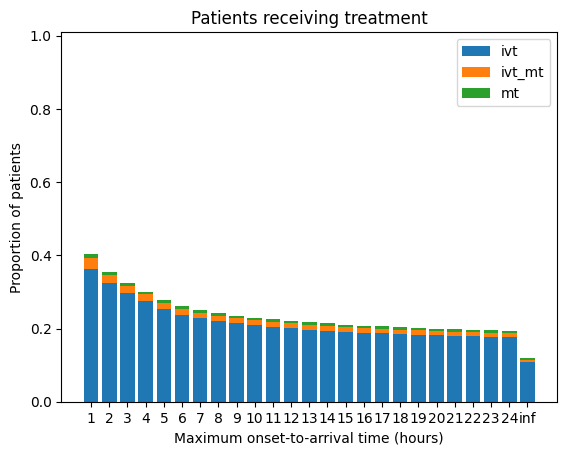

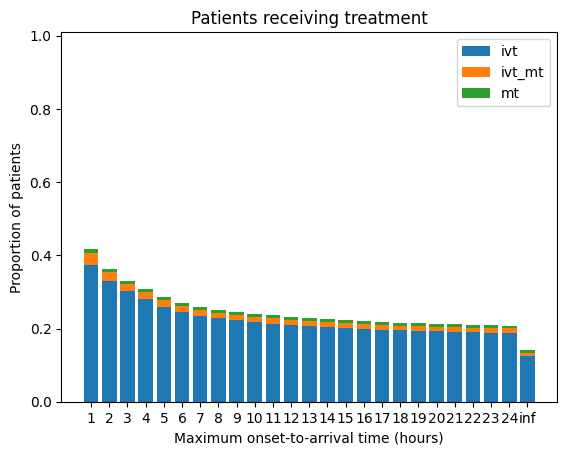

In [14]:
for df in [df_props_by_time, df_props_by_time_amboarrivals]:
    fig, ax = plt.subplots()
    
    bottoms = np.full(len(df), 0.0)
    for c, col in enumerate(['ivt', 'ivt_mt', 'mt']):
        heights = df[col].copy()
        if col == 'ivt_mt':
            bottoms -= df['ivt_mt'].copy()
        elif col == 'mt':
            heights -= df['ivt_mt']
        ax.bar(x=df.index, height=heights, bottom=bottoms, label=col)
        bottoms += heights
    
    ax.set_ylim(0, 1.01)
    ax.legend()
    ax.set_xlabel('Maximum onset-to-arrival time (hours)')
    ax.set_ylabel('Proportion of patients')
    ax.set_title('Patients receiving treatment')
    
    plt.show()

### Thrombolysed patients

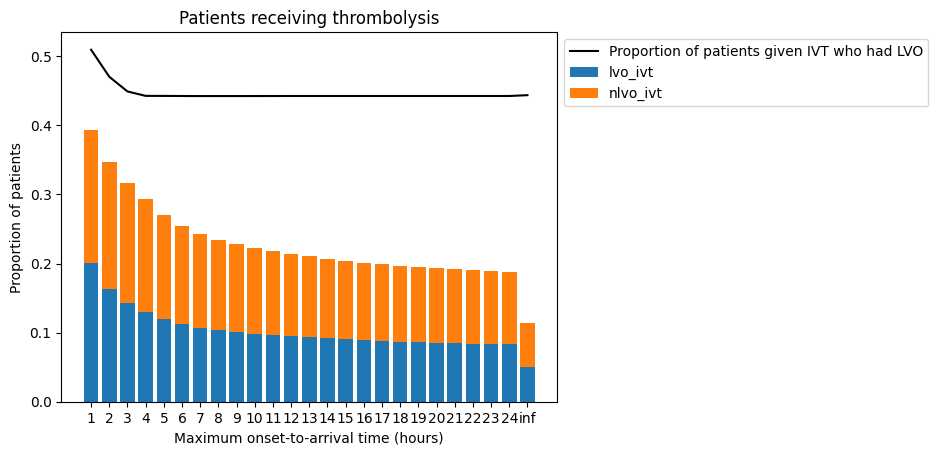

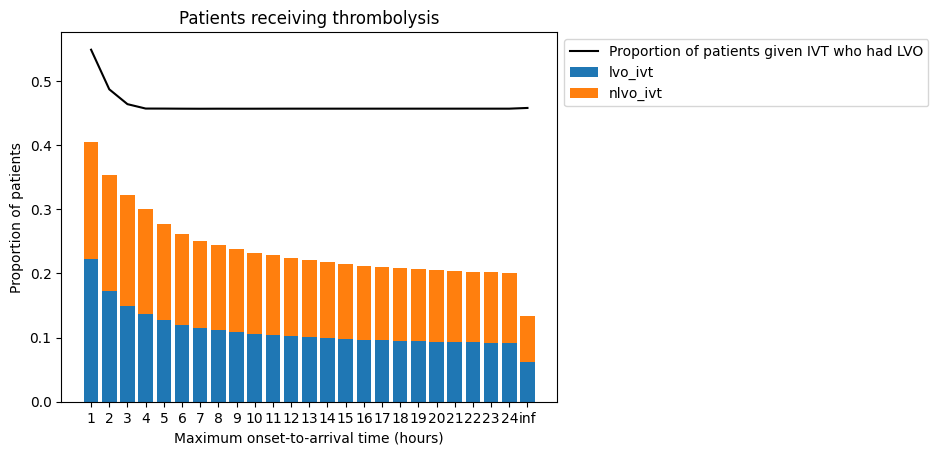

In [15]:
for df in [df_props_by_time, df_props_by_time_amboarrivals]:
    fig, ax = plt.subplots()

    bottoms = np.full(len(df), 0.0)
    for c, col in enumerate(['lvo_ivt', 'nlvo_ivt']):
        ax.bar(x=df.index, height=df[col], bottom=bottoms, label=col)
        bottoms += df[col]
    
    ax.plot(
        df.index,
        df['ivt_also_lvo'],
        label='Proportion of patients given IVT who had LVO',
        color='k'
    )
    
    # ax.set_ylim(0, 1)
    ax.legend(bbox_to_anchor=[1.0, 1.0], loc='upper left')
    ax.set_xlabel('Maximum onset-to-arrival time (hours)')
    ax.set_ylabel('Proportion of patients')
    ax.set_title('Patients receiving thrombolysis')
    
    plt.show()

I expect the line plateaus after around 4 hours because no more patients (in absolute numbers) receive thrombolysis after that point. The bars keep decreasing in size because more patients (in absolute numbers) join the subgroup but none of them receive IVT.

Check the values in the line:

In [16]:
df_props_by_time['ivt_also_lvo']

expected_onset_to_arrival_time
1      0.50959
2      0.47045
3      0.44917
4      0.44277
5      0.44273
6      0.44259
7      0.44248
8      0.44253
9      0.44251
10     0.44254
11     0.44257
12     0.44260
13     0.44260
14     0.44260
15     0.44260
16     0.44260
17     0.44260
18     0.44260
19     0.44260
20     0.44260
21     0.44260
22     0.44260
23     0.44260
24     0.44260
inf    0.44380
Name: ivt_also_lvo, dtype: float64

In [17]:
df_props_by_time_amboarrivals['ivt_also_lvo']

expected_onset_to_arrival_time
1      0.54859
2      0.48688
3      0.46376
4      0.45690
5      0.45685
6      0.45670
7      0.45661
8      0.45668
9      0.45665
10     0.45666
11     0.45670
12     0.45673
13     0.45673
14     0.45673
15     0.45673
16     0.45673
17     0.45673
18     0.45673
19     0.45673
20     0.45673
21     0.45673
22     0.45673
23     0.45673
24     0.45673
inf    0.45784
Name: ivt_also_lvo, dtype: float64

The value holds steady at 44.3% for the full SSNAP data and at 45.7% for the ambulance arrivals only.

### Thrombectomised patients

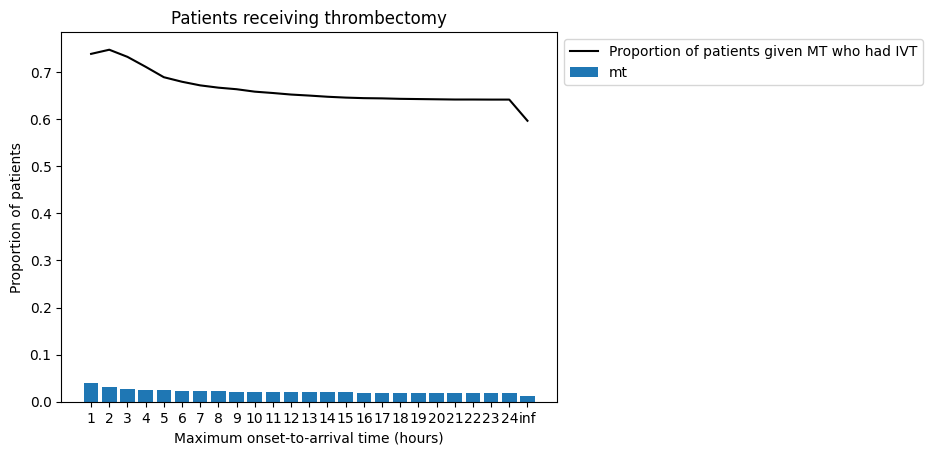

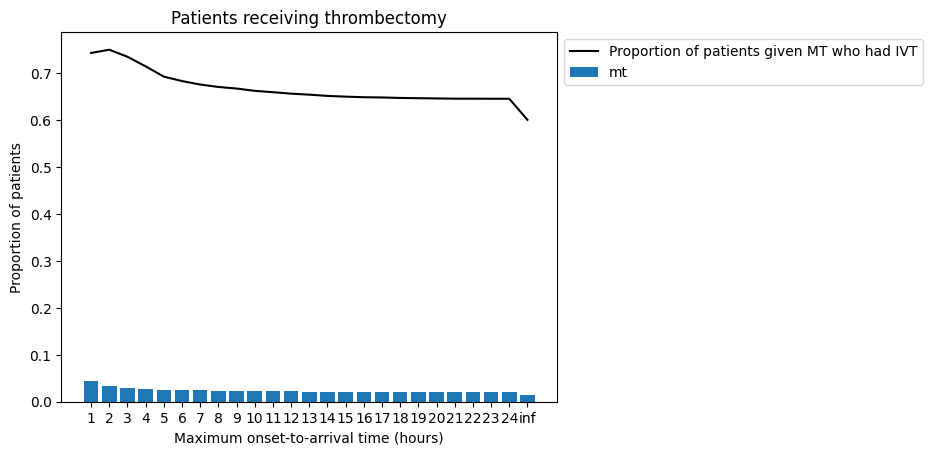

In [18]:
for df in [df_props_by_time, df_props_by_time_amboarrivals]:
    fig, ax = plt.subplots()
    
    bottoms = np.full(len(df), 0.0)
    for c, col in enumerate(['mt']):
        ax.bar(x=df.index, height=df[col], bottom=bottoms, label=col)
        bottoms += df[col]
    
    ax.plot(
        df.index,
        df['mt_also_ivt'],
        label='Proportion of patients given MT who had IVT',
        color='k'
    )
    
    # ax.set_ylim(0, 1)
    ax.legend(bbox_to_anchor=[1.0, 1.0], loc='upper left')
    ax.set_xlabel('Maximum onset-to-arrival time (hours)')
    ax.set_ylabel('Proportion of patients')
    ax.set_title('Patients receiving thrombectomy')
    
    plt.show()

The line here takes longer to plateau, not reaching a steady value within the first 12 hours after stroke onset.

Check the values in the line:

In [19]:
df_props_by_time['mt_also_ivt']

expected_onset_to_arrival_time
1      0.73867
2      0.74749
3      0.73233
4      0.71126
5      0.68913
6      0.67947
7      0.67179
8      0.66693
9      0.66361
10     0.65845
11     0.65556
12     0.65229
13     0.65012
14     0.64763
15     0.64582
16     0.64467
17     0.64418
18     0.64320
19     0.64271
20     0.64223
21     0.64174
22     0.64174
23     0.64158
24     0.64158
inf    0.59659
Name: mt_also_ivt, dtype: float64

In [20]:
df_props_by_time_amboarrivals['mt_also_ivt']

expected_onset_to_arrival_time
1      0.74336
2      0.75020
3      0.73519
4      0.71480
5      0.69286
6      0.68339
7      0.67599
8      0.67083
9      0.66750
10     0.66256
11     0.65967
12     0.65655
13     0.65442
14     0.65178
15     0.65020
16     0.64898
17     0.64846
18     0.64742
19     0.64690
20     0.64638
21     0.64587
22     0.64587
23     0.64569
24     0.64569
inf    0.60083
Name: mt_also_ivt, dtype: float64

The value falls towards 64.2% for the full SSNAP data and 64.6% for the ambulance arrivals only.

## Conclusion

We have saved a copy of the patient proportions at various onset-to-arrival cutoff times.

Some useful values for future use:

| Property | Full data value at 6hr | Full data value at 24hr | Ambulance arrivals value at 6hr | Ambulance arrivals value at 24hr |
| --- | --- | --- | --- | --- |
| Proportion of patients with IVT who had LVO | 0.44259 | 0.44260 | 0.45670 | 0.45673 |
| Proportion of patients with MT who also had IVT | 0.67947 | 0.64158 | 0.68339 | 0.64569 |

Recommended values:

| Property | Full data | Ambulance arrivals |
| --- | --- | --- |
| Proportion of patients with IVT who had LVO | 44.3% | 45.7% |
| Proportion of patients with MT who also had IVT | 64.2% | 64.6% |

These values are all fairly close so we could round these further to:

| Property | Recommended value |
| --- | --- |
| Proportion of patients with IVT who had LVO | 45% |
| Proportion of patients with MT who also had IVT | 65% |